In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import os
import scipy.optimize as optimization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  





:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Problem description

### Model
$ y = I\,e^{-a\,x_1}\,\cos(b\,x_0) $

- There is no (sturctural) model uncertainty

### True parameters
$I = 10.$

$a = 0.2$

$b = 8.0$

### True input distribution
$p(x_0) = VonMisses(mu=3 \pi/2.,k=\pi/6.)$

$p(x_1) = Weibull(A=2,k=10*cos(x_0))$

### Input Measurement Distribution
$p(\tilde{x_0}|x_0) = Normal(\mu=x_0,\sigma_{x_0})$

$p(\tilde{x_1}|x_1) = Normal(\mu=x_1,\sigma_{x_1})$

### Output Measurement Distribution
$p(\tilde{y}|y) = Normal(\mu=y,\sigma_y)$





In [2]:
def model(x0,x1,a,b,I):
    return I*np.exp(-a*x1)*np.cos(b*x0)

# Synthetica data

In [3]:
VonMises = cp.construct(
     cdf=lambda self,q,kappa,loc: stats.vonmises.cdf(q, kappa, loc),#*(0<=q<2*np.pi),
     bnd=lambda self,kappa,loc: (0,2*np.pi),
     pdf=lambda self,q,kappa,loc: stats.vonmises.pdf(q, kappa, loc),
     ppf=lambda self,u,kappa,loc: stats.vonmises.ppf(u, kappa, loc),
     mom=lambda self,k,kappa,loc: stats.vonmises.moment(k, kappa, loc),
     defaults=dict(kappa=1., loc=0.),
     str=lambda self,kappa,loc: ("VM%s%s" % (kappa, loc)))

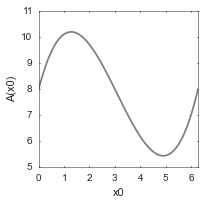

In [4]:
x0_pdf = np.linspace(0.,2.*np.pi,100)

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x0_pdf,0.2*(x0_pdf+0.)*(x0_pdf-3.)*(x0_pdf-2.*np.pi)+8,'k',alpha=0.5)
ax.set_xlabel('x0')
ax.set_ylabel('A(x0)')
ax.set_xlim([0.,2.*np.pi])
fig.tight_layout()
print

In [6]:
dist_x0 = VonMises(kappa=.2,loc=4.*np.pi/4.)
dist_x1 = cp.Weibull(shape=2., scale=0.2*(dist_x0+1.)*(dist_x0-3.)*(dist_x0-2.*np.pi)+8, shift=0)
dist_x = cp.J(dist_x0,dist_x1)

sigma_x0 = np.deg2rad(5)
dist_meas_x0 = cp.Normal(mu=0., sigma=sigma_x0)
sigma_x1 = 0.5 
dist_meas_x1 = cp.Normal(mu=0., sigma=sigma_x1)
dist_meas_x = cp.J(dist_meas_x0,dist_meas_x1)

sigma_y = 1.
dist_meas_y = cp.Normal(mu=0., sigma=sigma_y) 

N_meas = 1000
x_true_sample = dist_x.sample(size=N_meas,rule='H')
y_true_sample = model(x_true_sample[0,:],x_true_sample[1,:],a=.2,b=8.,I=10.)

epsilon_x_sample = dist_meas_x.sample(size=N_meas,rule='R')
epsilon_y_sample = dist_meas_y.sample(size=N_meas,rule='R')

x_tilde = x_true_sample+epsilon_x_sample
y_tilde = y_true_sample+epsilon_y_sample



In [7]:
folder = 'Figures/c2_Sx0_'+str(np.rad2deg(sigma_x0)).replace('.','p')+'_Sx1_'+str(sigma_x1).replace('.','p')+'_Sy_'+str(sigma_y).replace('.','p')+'/'
if not os.path.exists(folder): os.mkdir(folder)

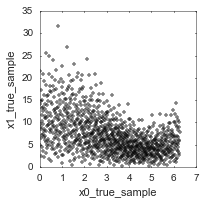

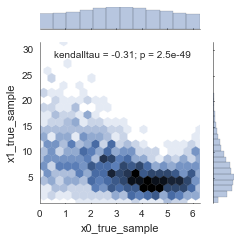

In [8]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x_true_sample[0,:],x_true_sample[1,:],'.k',alpha=0.5)
ax.set_xlabel('x0_true_sample')
ax.set_ylabel('x1_true_sample')

fig.tight_layout()
fig.savefig(folder+'c_x_true_sample.pdf')
print

fig=sns.jointplot(
    x_true_sample[0,:],
    x_true_sample[1,:], 
    kind="hex", 
    stat_func=stats.kendalltau,
    size=3.5
    )

fig.set_axis_labels('x0_true_sample','x1_true_sample')
fig = plt.gcf()
fig.tight_layout()
fig.savefig(folder+'c_x_true_hist.pdf')
print

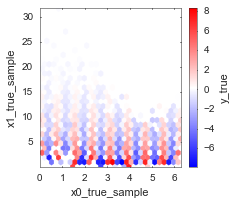

In [115]:
fig = plt.figure(figsize=[3.4,3])
ax = fig.add_subplot(111)
cm=ax.hexbin(x=x_true_sample[0,:],y=x_true_sample[1,:],C=y_true_sample,cmap=plt.cm.bwr, gridsize=30)
ax.set_xlabel('x0_true_sample')
ax.set_ylabel('x1_true_sample')
cb = fig.colorbar(cm)
cb.set_label('y_true')
fig.tight_layout()
fig.savefig(folder+'c_xy_true.pdf')
print

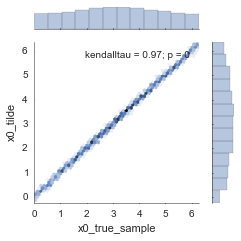

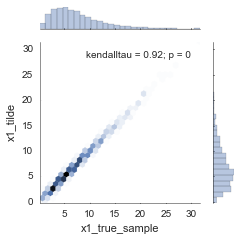

In [10]:
fig=sns.jointplot(
    x_true_sample[0,:],
    x_tilde[0,:], 
    kind="hex", 
    stat_func=stats.kendalltau,
    size=3.5,
    gridsize=50
    )

fig.set_axis_labels('x0_true_sample','x0_tilde')
fig = plt.gcf()
fig.tight_layout()
fig.savefig(folder+'c_x0_true_tilde.pdf')
print

fig=sns.jointplot(
    x_true_sample[1,:],
    x_tilde[1,:], 
    kind="hex", 
    stat_func=stats.kendalltau,
    size=3.5,
    gridsize=30
    )

fig.set_axis_labels('x1_true_sample','x1_tilde')
fig = plt.gcf()
fig.tight_layout()
fig.savefig(folder+'c_x1_true_tilde.pdf')
print

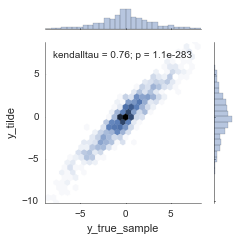

In [11]:
fig=sns.jointplot(
    y_true_sample,
    y_tilde, 
    kind="hex", 
    stat_func=stats.kendalltau,
    size=3.5
    )

fig.set_axis_labels('y_true_sample','y_tilde')
fig = plt.gcf()
fig.tight_layout()
fig.savefig(folder+'c_y_true_tilde.pdf')
print

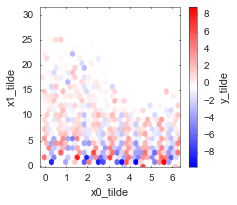

In [116]:
fig = plt.figure(figsize=[3.4,3])
ax = fig.add_subplot(111)
cm=ax.hexbin(x=x_tilde[0,:],y=x_tilde[1,:],C=y_tilde,cmap=plt.cm.bwr, gridsize=30)
ax.set_xlabel('x0_tilde')
ax.set_ylabel('x1_tilde')
cb = fig.colorbar(cm)
cb.set_label('y_tilde')
fig.tight_layout()
fig.savefig(folder+'c_xy_tilde.pdf')
print

# a1) Bayesian inference ussing PCE. 

### Prior parameters
$I = 10.$

$a = Uniform[0.1,0.3]$

$b = 0.5$

In [56]:
prior_a = cp.Uniform(0.1,0.3) #cp.Normal(0.2,0.05)
dist_meas_y_Bayes = cp.Normal(mu=0., sigma=sigma_y) 

In [57]:
def f(x0,x1,a,i):
    error_y = y_tilde[i]*np.ones_like(a)-model(x0,x1,a,b=8.,I=10.)
    return (dist_meas_x0.pdf(x_tilde[0,i]-x0)*dist_meas_x1.pdf(x_tilde[1,i]-x1)*dist_meas_y_Bayes.pdf(error_y))

Discretizetion of the parameter space

In [58]:
a_eval = np.linspace(0.1,0.3,500)

### PCE with respect pdf(x)

In [59]:
# Uncorrelated Standard Normals
dist_R = cp.J(cp.Uniform(),cp.Uniform())

In [60]:
M = 9    # Order of the polynomial
N = M + 1 # Number of terms, evaluations per dimension

In [61]:
# Polynomial for Uniform: 
P = cp.orth_ttr(M, dist_R)

In [117]:
# Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]

# Exponenial rule 
nodes_R = dist_R.sample(2**M-1,rule='M') 

# Fixed number of nodes
#nodes_R = dist_R.sample(100,rule='M') 

# Rosenblatt Transformation
nodes = dist_x.inv(dist_R.fwd(nodes_R))

N_cal = 1000
ind_nonvalid =[]
E_x_f = np.ones([len(a_eval),N_cal])
for i in range(N_cal):
    sample_f_nodes = np.array([f(x0=node[0],x1=node[1],a=a_eval,i=i) for node in nodes.T])
    y_hat = cp.fit_regression(P, nodes_R, sample_f_nodes) 
    E_x_f_i = cp.E(y_hat, dist_R)
    C_ = np.mean(E_x_f_i)
    if  (C_>0)&(E_x_f_i.min()>0):#1e-6
        E_x_f[:,i] = E_x_f_i#/C_
    else:
        ind_nonvalid.append(i)
        E_x_f[:,i] = np.ones_like(E_x_f_i)

In [118]:
ind = [i for i in range(N_cal) if i not in ind_nonvalid]

post_a = prior_a.pdf(a_eval)
for i in ind:
    if i not in ind_nonvalid:
        post_a_old = post_a
        post_a = E_x_f[:,i]*post_a_old

        C_ = np.trapz(post_a,a_eval)
        if  (C_>0):
            post_a = post_a/C_
        else:
            ind_nonvalid.append(i)
            post_a = post_a_old

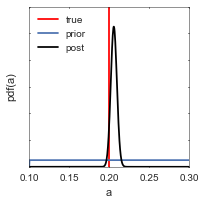

In [119]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.axvline(0.2,color='r',label='true')
ax.plot(a_eval,prior_a.pdf(a_eval),label='prior')
ax.plot(a_eval,post_a,'k',label='post')

ax.set_xlabel('a')
ax.set_ylabel('pdf(a)')
ax.legend(loc='upper left')
ax.set_yticklabels([])
fig.tight_layout()
#fig.savefig(folder+'a_post_'+label+'.pdf')
print

Non valid =  1


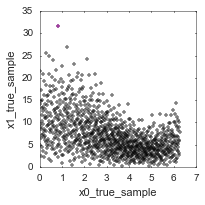

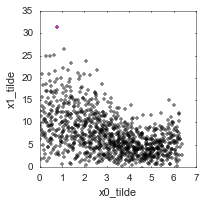

In [121]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x_true_sample[0,:],x_true_sample[1,:],'.k',alpha=0.5)
ax.plot(x_true_sample[0,ind_nonvalid],x_true_sample[1,ind_nonvalid],'.m',alpha=0.5)
ax.set_xlabel('x0_true_sample')
ax.set_ylabel('x1_true_sample')

fig.tight_layout()
fig.savefig(folder+'c_x_true_non_informative.pdf')

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(x_tilde[0,:],x_tilde[1,:],'.k',alpha=0.5)
ax.plot(x_tilde[0,ind_nonvalid],x_tilde[1,ind_nonvalid],'.m',alpha=0.5)
ax.set_xlabel('x0_tilde')
ax.set_ylabel('x1_tilde')
ax.set_xlim([0,7])
ax.set_ylim([0,35])
fig.tight_layout()
fig.savefig(folder+'c_x_tilde_non_informative.pdf')
print 'Non valid = ', len(ind_nonvalid)

In [122]:
bins_x0=np.arange(0.,2.*np.pi+0.01,np.deg2rad(5))
bins_x1=np.arange(0.,31,1.)

n_bin = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=y_tilde, statistic='count', 
                                  bins=[bins_x0,bins_x1])[0]

x0_tilde_bin_E = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=x_tilde[0,:], statistic='mean', 
                                           bins=[bins_x0,bins_x1])[0]
x0_tilde_bin_S = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=x_tilde[0,:], statistic=stats.sem, 
                                           bins=[bins_x0,bins_x1])[0]

x1_tilde_bin_E = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=x_tilde[1,:], statistic='mean', 
                                           bins=[bins_x0,bins_x1])[0]
x1_tilde_bin_S = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=x_tilde[1,:], statistic=stats.sem, 
                                           bins=[bins_x0,bins_x1])[0]

y_tilde_bin_E = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=y_tilde, statistic='mean', 
                                           bins=[bins_x0,bins_x1])[0]
y_tilde_bin_S = stats.binned_statistic_2d(x=x_tilde[0,:], y=x_tilde[1,:], values=y_tilde, statistic=stats.sem, 
                                           bins=[bins_x0,bins_x1])[0]

print

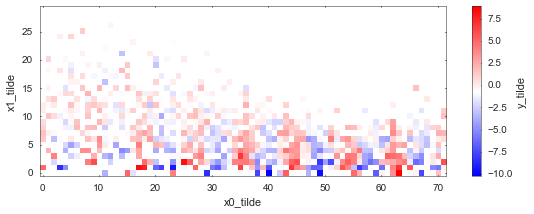

In [123]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_subplot(111)
cm=ax.imshow(y_tilde_bin_E.T, origin='lower',interpolation='nearest',cmap=plt.cm.bwr)
ax.set_xlabel('x0_tilde')
ax.set_ylabel('x1_tilde')
cb = fig.colorbar(cm)
cb.set_label('y_tilde')
fig.tight_layout()
fig.savefig(folder+'c_xy_tilde_binned.pdf')

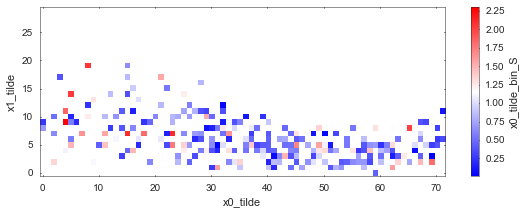

In [124]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_subplot(111)
cm=ax.imshow(np.rad2deg(x0_tilde_bin_S.T), origin='lower',interpolation='nearest',cmap=plt.cm.bwr)
ax.set_xlabel('x0_tilde')
ax.set_ylabel('x1_tilde')
cb = fig.colorbar(cm)
cb.set_label('x0_tilde_bin_S')
fig.tight_layout()
#fig.savefig(folder+'c_xy_tilde_binned.pdf')

In [132]:
def f_SEM(x0,x1,a,i):
    error_x0 = x0_tilde_bin_E.flatten()[i]-x0
    error_x1 = x1_tilde_bin_E.flatten()[i]-x1
    error_y = y_tilde_bin_E.flatten()[i]*np.ones_like(a)-model(x0,x1,a,b=8.,I=10.)
    '''
    return cp.Normal(mu=0., sigma=x0_tilde_bin_S.flatten()[i]).pdf(error_x0)\
          *cp.Normal(mu=0., sigma=x1_tilde_bin_S.flatten()[i]).pdf(error_x1)\
          *cp.Normal(mu=0., sigma=y_tilde_bin_S.flatten()[i]).pdf(error_y)    
    '''
    return cp.Normal(mu=0., sigma=(sigma_x0**2.+x0_tilde_bin_S.flatten()[i]**2.)**0.5).pdf(error_x0)\
          *cp.Normal(mu=0., sigma=(sigma_x1**2.+x1_tilde_bin_S.flatten()[i]**2.)**0.5).pdf(error_x1)\
          *cp.Normal(mu=0., sigma=(sigma_y**2.+y_tilde_bin_S.flatten()[i]**2.)**0.5).pdf(error_y)
    
    print

In [133]:
# Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]

# Exponenial rule 
nodes_R = dist_R.sample(2**M-1,rule='M') 

# Fized number of nodes
#nodes_R = dist_R.sample(80,rule='M') 
nodes = dist_x.inv(dist_R.fwd(nodes_R))

N_cal = len(y_tilde_bin_E.flatten())#
ind_nonvalid =[]
E_x_f_SEM = np.ones([len(a_eval),N_cal])
for i in range(N_cal):
    sample_y_nodes = np.array([f_SEM(x0=node[0],x1=node[1],a=a_eval,i=i) for node in nodes.T])
    y_hat = cp.fit_regression(P, nodes_R, sample_y_nodes)
    E_x_f_i = cp.E(y_hat, dist_R)
    C_ = np.mean(E_x_f_i)
    if  (C_>1e-6):
        E_x_f_SEM[:,i] = E_x_f_i#/C_
    else:
        ind_nonvalid.append(i)
        E_x_f_SEM[:,i] = np.ones_like(E_x_f_i)

In [134]:
N_tilde = N_cal 

ind = [i for i in range(N_cal) if i not in ind_nonvalid]

post_a_SEM = prior_a.pdf(a_eval)
for i in ind:
    if (i not in ind_nonvalid)&(i<N_tilde):
        post_a_old = post_a_SEM
        post_a_SEM = E_x_f_SEM[:,i]*post_a_old

        C_ = np.trapz(post_a_SEM,a_eval)
        if  (C_>0):
            post_a_SEM = post_a_SEM/C_
        else:
            ind_nonvalid.append(i)
            post_a_SEM = post_a_old

In [128]:
def model_LSQfit(x,a):
    b=2.0
    I=10.
    x0=x[0,:]
    x1=x[1,:]
    return I*np.exp(-a*x1)*np.cos(b*x0)

In [129]:
LSQ = optimization.curve_fit(f=model_LSQfit, xdata=x_tilde, ydata=y_tilde, p0=0.15, sigma=sigma_y)
ind = np.where(np.isnan(y_tilde_bin_S.flatten())==0)
LSQ_bin = optimization.curve_fit(f=model_LSQfit, xdata=np.vstack([x0_tilde_bin_E.flatten()[ind],x1_tilde_bin_E.flatten()[ind]]), 
                             ydata=y_tilde_bin_E.flatten()[ind], p0=0.15, sigma=y_tilde_bin_S.flatten()[ind])
print LSQ[0][0]
print LSQ[1][0][0]
print
print LSQ_bin[0][0]
print LSQ_bin[1][0][0]

2.33342813589
0.269177768484

0.310655027752
0.0001463920765


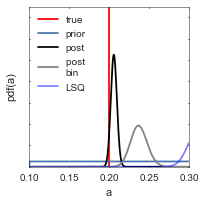

In [135]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.axvline(0.2,color='r',label='true')
ax.plot(a_eval,prior_a.pdf(a_eval),label='prior')
ax.plot(a_eval,post_a,'k',label='post')
ax.plot(a_eval,post_a_SEM,'gray',label='post \nbin')

ax.plot(a_eval,cp.Normal(LSQ_bin[0][0],(LSQ_bin[1][0][0])**0.5).pdf(a_eval),'b',label='LSQ',alpha=0.5)

ax.set_xlabel('a')
ax.set_ylabel('pdf(a)')
ax.legend(loc='upper left')
ax.set_ylim([0,150])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig(folder+'c_post_'+'comp'+'.pdf')
print

In [136]:
print len(ind_nonvalid)
print N_cal

1921
2160
